<a href="https://colab.research.google.com/github/distributed-information-bottleneck/distributed-information-bottleneck.github.io/blob/main/complex_systems/InfoDecomp_Boolean_circuits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
This code accompanies
"Information decomposition in complex systems via machine learning"
Kieran A Murphy and Dani S Bassett
PNAS 2024

The following decomposes the information contained in the inputs of a Boolean
circuit.  Specifically, it reproduces the 10-input Boolean circuit analysis
(Fig. 1) and the additional circuits in the SI (Fig. S1).  For the additional
circuits, we compare to feature importance derived from logistic regression on
the truth table and Shapley values in regards to the mutual information with the
output Y.
'''

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import scipy.ndimage as nim
import os
from sklearn.linear_model import LogisticRegression
from scipy.special import comb

default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [ ]:
#@title Mutual information estimation
def estimate_mi_sandwich_bounds(encoder,
  dataset, evaluation_batch_size=1024, number_evaluation_batches=8):
  """Computes the upper and lower bounds of mutual information transmitted by an encoder, given the dataset.

  With X and U the random variables representing the data and the compressed
  messages, respectively, we assume the conditional distribution output by the
  encoder p(u|x) is a diagonal Gaussian in latent space and parameterized by the
  center and log variance values.  As the conditional distribution is known, we
  can use the InfoNCE lower and "leave one out" upper bounds from Poole et al.
  (2019).  See the manuscript and/or colab notebook for analysis of the bounds
  up to several bits of transmitted information.

  Args:
    encoder: TF model that produces an encoding U given input data
      (no assumptions about architecture of the model or form of the data).
    dataset: tensorflow.data.Dataset that yields data of a single feature.
    evaluation_batch_size: The number of data points to use for each batch when
      estimating the upper and lower bounds.  Increasing this parameter yields
      tighter bounds on the mutual information.
    number_evaluation_batches: The number of batches over which to average the
      upper and lower bounds.  Increasing this parameter reduces the uncertainty
      of the bounds.
  Returns:
    Lower and upper bound estimates for the communication channel represented by
    the encoder.
  """
  @tf.function
  def compute_batch(batch_data):
    mus, logvars = tf.split(encoder(batch_data), 2, axis=-1)
    # We desire extra numerical precision below; cast to float64
    mus = tf.cast(mus, tf.float64)
    logvars = tf.cast(logvars, tf.float64)
    embedding_dimension = tf.shape(mus)[-1]
    stddevs = tf.exp(logvars/2.)
    sampled_u_values = tf.random.normal(mus.shape, mean=mus,
                                        stddev=stddevs, dtype=tf.float64)
    # Expand dimensions to broadcast and compute the pairwise distances between
    # the sampled points and the centers of the conditional distributions
    sampled_u_values = tf.reshape(sampled_u_values,
     [evaluation_batch_size, 1, embedding_dimension])
    mus = tf.reshape(mus, [1, evaluation_batch_size, embedding_dimension])
    distances_ui_muj = sampled_u_values - mus

    normalized_distances_ui_muj = distances_ui_muj / tf.reshape(stddevs, [1, evaluation_batch_size, embedding_dimension])
    p_ui_cond_xj = tf.exp(-tf.reduce_sum(normalized_distances_ui_muj**2, axis=-1)/2. - \
      tf.reshape(tf.reduce_sum(logvars, axis=-1), [1, evaluation_batch_size])/2.)
    normalization_factor = (2.*np.pi)**(tf.cast(embedding_dimension, tf.float64)/2.)
    p_ui_cond_xj = p_ui_cond_xj / normalization_factor
    # InfoNCE (lower bound) is the diagonal terms over their rows, averaged
    p_ui_cond_xi = tf.linalg.diag_part(p_ui_cond_xj)
    avg_pui_cond_xj = tf.reduce_mean(p_ui_cond_xj, axis=1)
    infonce_lower = tf.reduce_mean(tf.math.log(p_ui_cond_xi/tf.reduce_mean(p_ui_cond_xj, axis=1)))
    # "Leave one out" (upper bound) is the same but without the diagonal term in the denom
    p_ui_cond_xj *= (1. - tf.eye(evaluation_batch_size, dtype=tf.float64))
    loo_upper = tf.reduce_mean(tf.math.log(p_ui_cond_xi/tf.reduce_mean(p_ui_cond_xj, axis=1)))
    return infonce_lower, loo_upper

  # number_evaluation_batches*evaluation_batch_size can be larger than the dataset
  # We gain from re-sampling u even if we have seen the data point x before
  bound_estimates = []
  for batch_data in dataset.repeat().shuffle(evaluation_batch_size*10).batch(evaluation_batch_size).take(number_evaluation_batches):
    bound_estimates.append(compute_batch(batch_data))

  return np.mean(np.stack(bound_estimates, 0), 0)

In [ ]:
class SimpleEncoder(tf.keras.layers.Layer):
  """Simple encoder for a binary-valued variable.

  With two trainable constants, mu and logvar, this encoder maps +1/-1 to a
  normal distribution with mean +mu/-mu and log variance of logvar.
  """
  def __init__(self):
      super(SimpleEncoder, self).__init__()

  def build(self, input_shape):
    self.mu_scaling = tf.Variable(
        initial_value=tf.ones(shape=(1, 1),
                              dtype='float32'),
        trainable=True)
    self.logvar = tf.Variable(
        initial_value=-3.*tf.ones(shape=(1, 1), dtype='float32'),
        trainable=True)
    return

  def call(self, inputs):
      return tf.concat([inputs*self.mu_scaling, tf.ones_like(inputs)*self.logvar], -1)

In [ ]:
gates = [np.logical_and, np.logical_or, np.logical_xor]

# This is the circuit from the paper, formatted such that each intermediate output is defined by the contents of the brackets: [gate_id, input1, input2]
circuit_specification = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, [1, 0, 1], [2, 8, 7], [0, 4, 3], [1, 11, 5], [2, 6, 12], [2, 13, 9], [1, 14, 10], [0, 15, 2], [0, 17, 16]]
number_input_gates = 10

def apply_gates(inputs, circuit_specification):
  intermed = inputs
  for thing in circuit_specification[inputs.shape[-1]:]:
    intermed = np.concatenate([intermed, np.int32(gates[thing[0]](intermed[:, thing[1]], intermed[:, thing[2]]))[:, np.newaxis]], -1)
  return intermed

def compute_entropy(vals):
  # assume that vals come from a truth table, so every occurrence is weighted
  # equally
  # it's either a column or multiple columns, and the entries are 0 or 1
  if len(vals.shape) == 2:
    # convert each row to binary
    vals = np.int32([int(''.join([str(v) for v in row]), 2) for row in vals])
  probs = np.bincount(vals)/float(vals.shape[0])
  probs = probs[probs>0]
  return -np.sum(probs * np.log2(probs))

def compute_info(vals1, vals2):
  if len(vals1.shape) == 1:
    vals1 = np.expand_dims(vals1, -1)
  if len(vals2.shape) == 1:
    vals2 = np.expand_dims(vals2, -1)
  return compute_entropy(vals1) + compute_entropy(vals2) - compute_entropy(np.concatenate([vals1, vals2], -1))

# Evaluate the full truth table
possible_inputs = np.meshgrid(*[[0, 1]]*number_input_gates)
possible_inputs = np.stack(possible_inputs, -1)
possible_inputs = np.reshape(possible_inputs, [-1, number_input_gates])

truth_table = apply_gates(possible_inputs, circuit_specification)
# The truth table includes the values for all the intermediate gate outputs
# Let's throw those out
truth_table = np.concatenate([truth_table[:, :number_input_gates], truth_table[:, -1:]], -1)
y = truth_table[:, -1]
entropy_y = compute_entropy(y)
print(f'Entropy of Y: {entropy_y:.3f} bits.')

Entropy of Y: 0.758 bits.


Finished step 0/50000
Finished step 2000/50000
Finished step 4000/50000
Finished step 6000/50000
Finished step 8000/50000
Finished step 10000/50000
Finished step 12000/50000
Finished step 14000/50000
Finished step 16000/50000
Finished step 18000/50000
Finished step 20000/50000
Finished step 22000/50000
Finished step 24000/50000
Finished step 26000/50000
Finished step 28000/50000
Finished step 30000/50000
Finished step 32000/50000
Finished step 34000/50000
Finished step 36000/50000
Finished step 38000/50000
Finished step 40000/50000
Finished step 42000/50000
Finished step 44000/50000
Finished step 46000/50000
Finished step 48000/50000

Finished training, onto plotting


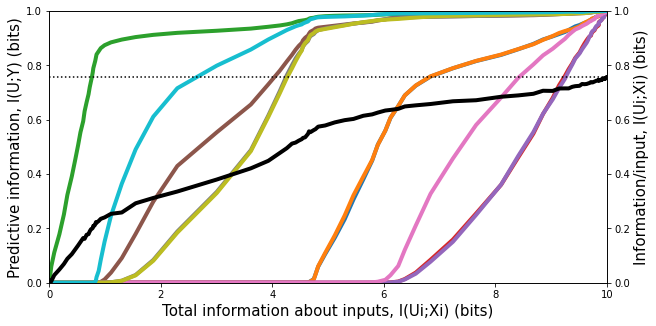

In [ ]:
learning_rate = 1e-3
number_training_steps = 5*10**4
batch_size = 512
beta_start, beta_end = [1e-3, 1e0]
beta_end = 5e0
opt = tf.keras.optimizers.Adam(learning_rate)
bce_loss_series = []
beta_var = tf.Variable(beta_start, dtype=tf.float32, trainable=False)
##############################################################################
# Network creation
# The encoders are trainable constants, taking each binary 0/1 to a normal
# distribution in representation space with +-mu as the mean
#
# Because we want to use our own feature encoders, we can't easily use the
# DistributedIBNet class (where each feature encoder is an MLP)
# This is an example where the loss computation must be done out in the open,
# defined in train_step()
feature_encoders = [SimpleEncoder() for _ in range(number_input_gates)]

predictive_model = tf.keras.Sequential([tf.keras.layers.Input((number_input_gates,)),
          tf.keras.layers.Dense(256, 'leaky_relu'),
          tf.keras.layers.Dense(256, 'leaky_relu'),
          tf.keras.layers.Dense(256, 'leaky_relu'),
          tf.keras.layers.Dense(1)])
trainable_variables = predictive_model.trainable_variables

dummy_x = tf.ones((2, 1))
for network in feature_encoders:
  network(dummy_x)  ## build the network
  trainable_variables += network.trainable_variables

##############################################################################
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
@tf.function
def train_step():
  rand_samples = tf.random.categorical(tf.zeros((batch_size, truth_table.shape[0])), 1)
  batch_x = tf.gather(truth_table, rand_samples, axis=0)[:, 0, :number_input_gates]
  batch_x = tf.cast(batch_x, tf.float32)*2. - 1  ## map 0,1 -> -1,1

  batch_y = tf.gather(truth_table, rand_samples, axis=0)[:, 0, -1]
  batch_x_split = tf.split(batch_x, number_input_gates, axis=-1)

  kl_divergence_channels = []
  all_embeddings = []
  with tf.GradientTape() as tape:
    for gate_ind in range(number_input_gates):
      emb_mus, emb_logvars = tf.split(feature_encoders[gate_ind](batch_x_split[gate_ind]), 2, axis=-1)
      emb_reparameterized = tf.random.normal(emb_mus.shape, mean=emb_mus, stddev=tf.exp(emb_logvars/2.))
      all_embeddings.append(emb_reparameterized)
      kl = tf.reduce_mean(tf.reduce_sum(0.5 * (tf.square(emb_mus) + tf.exp(emb_logvars) - emb_logvars - 1.), axis=-1))
      kl_divergence_channels.append(kl)
    y_predicted = predictive_model(tf.concat(all_embeddings, -1))
    bce_loss = tf.reduce_mean(bce(batch_y, y_predicted))
    loss = bce_loss + beta_var*tf.reduce_sum(kl_divergence_channels)
  grads = tape.gradient(loss, trainable_variables)
  opt.apply_gradients(zip(grads, trainable_variables))
  return bce_loss

evaluate_mutual_info_freq = number_training_steps//200
mutual_information_bounds = []
for step in range(number_training_steps):
  # Logarithmically ramp beta over the course of training
  beta_var.assign(np.exp(np.log(beta_start)+float(step)/number_training_steps*(np.log(beta_end)-np.log(beta_start))))
  bce_loss = train_step()
  bce_loss_series.append(bce_loss.numpy())
  if step % evaluate_mutual_info_freq == 0:
    # Estimate the amount of information transmitted by each feature encoder
    for feature_encoder in feature_encoders:
      lower, upper = estimate_mi_sandwich_bounds(feature_encoder, tf.data.Dataset.from_tensor_slices([[-1.], [1]]))
      mutual_information_bounds.append([lower, upper])
  if step % (number_training_steps//25) == 0:
    print(f'Finished step {step}/{number_training_steps}')

print()
print('Finished training, onto plotting')

mutual_information_bounds = np.reshape(mutual_information_bounds, [-1, number_input_gates, 2])/np.log(2)

plot_lims_info_in_per = [0, 1.]
plot_lims_info_in_total = [0, 10]
plot_lims_info_out = [0, 1]

predictive_information_out = entropy_y - np.float32(bce_loss_series)/np.log(2)

## Just take the average of the upper and lower bounds to be the mutual information estimate
# See the manuscript and/or information bound colab -- the bounds should be separated by
# no more than ~0.01 bits for the entire optimization
transmitted_information_by_channel = np.mean(mutual_information_bounds, axis=-1)

# Average temporally a little bit
train_smoothing_sigma = 25
info_parts_smoothing_sigma = 1.5
info_full_smoothing_sigma = 0.5

info_in_parts = nim.filters.gaussian_filter1d(transmitted_information_by_channel, info_parts_smoothing_sigma, axis=0)
info_in_full = nim.filters.gaussian_filter1d(np.sum(transmitted_information_by_channel, axis=-1), info_full_smoothing_sigma)
predictive_information_out = nim.filters.gaussian_filter(predictive_information_out, train_smoothing_sigma)[::evaluate_mutual_info_freq]

plt.figure(figsize=(10, 5))
ax = plt.gca()
plot_start_ind = 5  # Start plotting after a brief initial warmup
ax.plot(info_in_full[plot_start_ind:], predictive_information_out[plot_start_ind:], lw=4, color='k')
ax.plot(plot_lims_info_in_total, [entropy_y]*2, 'k:')
ax.set_xlim(plot_lims_info_in_total)
ax.set_ylim(plot_lims_info_out)

ax2 = ax.twinx()
for gate_ind in range(number_input_gates):
  ax2.plot(info_in_full[plot_start_ind:], info_in_parts[plot_start_ind:, gate_ind], color=default_colors[gate_ind], lw=4)
ax2.set_ylim(plot_lims_info_in_per)
ax.set_zorder(ax2.get_zorder()+1)  # it looks better with the main DIB curve (black) in front of the per-channel information curves
ax.patch.set_visible(False)

ax.set_xlabel('Total information about inputs, I(Ui;Xi) (bits)', fontsize=15)
ax.set_ylabel('Predictive information, I(U;Y) (bits)', fontsize=15)
ax2.set_ylabel('Information/input, I(Ui;Xi) (bits)', fontsize=15)

plt.show()

Sequence of selected subsets: [array([0, 1, 2, 5, 6, 7, 8, 9]), array([0, 1, 2, 5, 7, 8, 9]), array([2, 5, 7, 8, 9]), array([2, 5, 9]), array([2, 9]), array([2]), array([], dtype=int64), range(0, 10)]


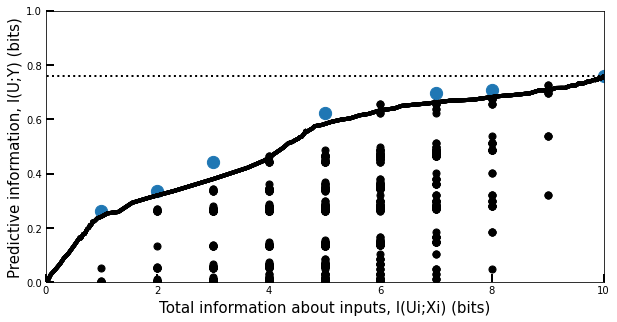

In [ ]:
# For comparison, compute mutual information between Y and all possible subsets of input gates
all_on_off_combos = np.meshgrid(*[[0, 1]]*number_input_gates)
all_on_off_combos = np.stack(all_on_off_combos, -1)
all_on_off_combos = np.reshape(all_on_off_combos, [-1, number_input_gates])
all_mis = [0]
for mi_term in all_on_off_combos[1:]:
  # each mi_term is 0s and 1s for if the input is included in the computation or not
  x = np.stack([truth_table[:, i] for i in np.where(mi_term)[0]], -1)
  mi = compute_info(x, y)
  all_mis.append(mi)

# Discretize the DIB information allocation across input gates into simple subsets
# of gates, indicating whether the transmitted information was above or below an
# arbitrary threshold of 0.1 bits
# We'll check whether the found subsets of input gates are also the subsets that
# contain the most information with Y for each subset size
information_threshold = 0.1
above_thresh_channels = info_in_parts>information_threshold
above_thresh_channels = np.cumprod(above_thresh_channels, axis=0)
sum_active = np.sum(above_thresh_channels, axis=-1)

change_indices = np.where((sum_active[1:]-sum_active[:-1])<0)[0]
input_subsets_above_threshold = []
for ind in change_indices:
  input_subsets_above_threshold.append(np.where(above_thresh_channels[ind+1])[0])
# Append the freebie, the full set of inputs:
input_subsets_above_threshold.append(range(number_input_gates))

print('Sequence of selected subsets:', input_subsets_above_threshold)

plt.figure(figsize=(10, 5))

for subset_size in range(1, number_input_gates+1):
  mutual_infos_sorted = np.sort(np.float32(all_mis)[np.where(np.sum(all_on_off_combos, -1)==subset_size)])[::-1]
  combination_indices = np.argsort(np.float32(all_mis)[np.where(np.sum(all_on_off_combos, -1)==subset_size)])[::-1]
  plt.scatter(np.ones(len(mutual_infos_sorted))*subset_size, mutual_infos_sorted, s=50, c='k')

  for info_index, bit_inclusion in enumerate(all_on_off_combos[np.where(np.sum(all_on_off_combos, -1)==subset_size)][combination_indices]):
    on_gates = np.where(bit_inclusion)
    ## Blow up the point for the subset found by the distributed IB, and color it based on its rank
    ## out of all the same sized subsets.  Blue = max, orange is second, green third, etc. (following matplotlib's default color cycle)
    if np.any([list(on_gates[0])==list(active_combo) for active_combo in input_subsets_above_threshold]):
      plt.scatter(subset_size, mutual_infos_sorted[info_index], s=150, c=default_colors[info_index])
      break

  plt.plot(info_in_full[plot_start_ind:], predictive_information_out[plot_start_ind:], lw=4, color='k')

plt.plot([-1, number_input_gates+1], [entropy_y]*2, 'k:', lw=2)
plt.xlabel('Total information about inputs, I(Ui;Xi) (bits)', fontsize=15)
plt.ylabel('Predictive information, I(U;Y) (bits)', fontsize=15)
plt.xlim(plot_lims_info_in_total)
plt.ylim(plot_lims_info_out)
plt.tick_params(which='both', width=2, length=8, direction='in')
plt.show()

# Additional circuits in the SI

****************************************************************************************************
Beginning circuit #1 aka circuit (a) in Fig. S1.
Circuit spec: [0, 1, 2, [2, 1, 2], [2, 0, 3]]
****************************************************************************************************
Finished step 0/50000
Finished step 5000/50000
Finished step 10000/50000
Finished step 15000/50000
Finished step 20000/50000
Finished step 25000/50000
Finished step 30000/50000
Finished step 35000/50000
Finished step 40000/50000
Finished step 45000/50000

Finished training, onto plotting


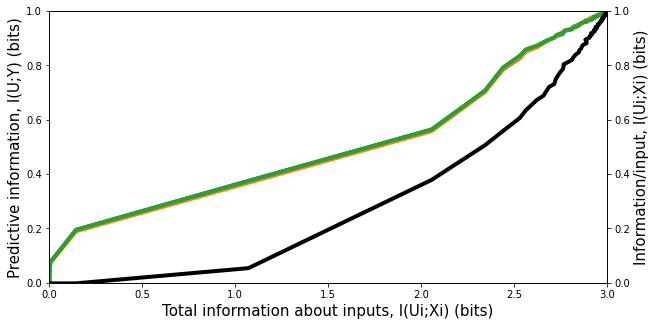

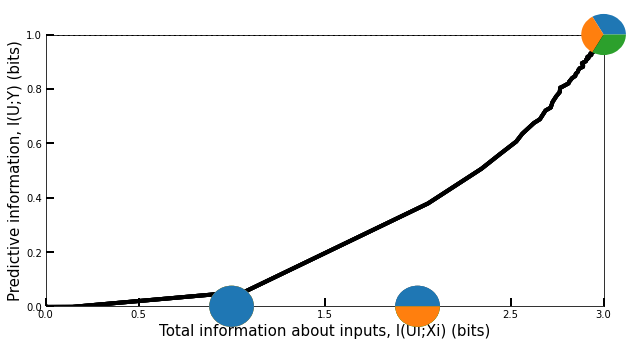

Logistic regression accuracy: 0.500
Logistic regression coefficients: [0. 0. 0.]
I(U;Y)=0.000 bits, H(Y)=1.000 bits
****************************************************************************************************
H(Y)=1.000, Sum of Shapley values = 1.000
Shapley values: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
****************************************************************************************************


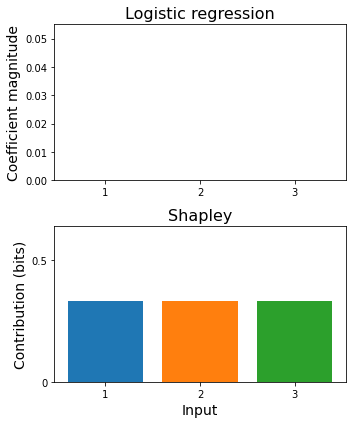

****************************************************************************************************
Beginning circuit #2 aka circuit (b) in Fig. S1.
Circuit spec: [0, 1, 2, [0, 1, 0], [2, 2, 3]]
****************************************************************************************************
Finished step 0/50000
Finished step 5000/50000
Finished step 10000/50000
Finished step 15000/50000
Finished step 20000/50000
Finished step 25000/50000
Finished step 30000/50000
Finished step 35000/50000
Finished step 40000/50000
Finished step 45000/50000

Finished training, onto plotting


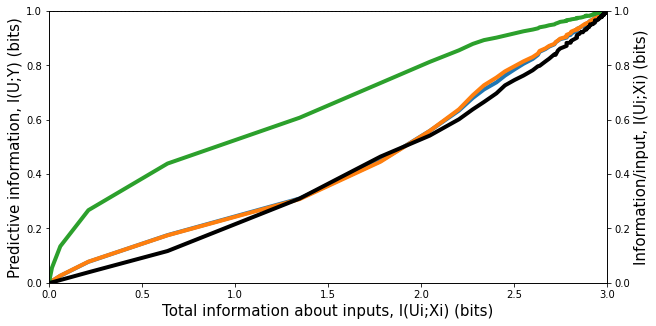

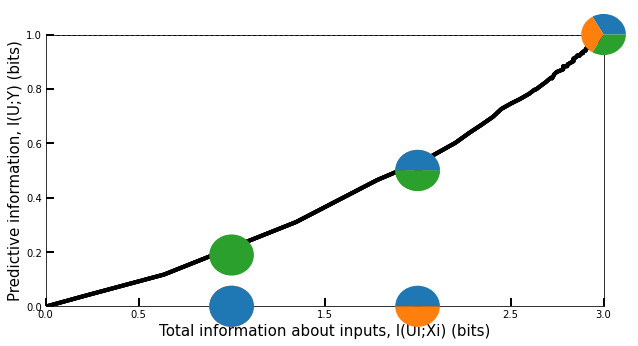

Logistic regression accuracy: 0.750
Logistic regression coefficients: [5.13142286e-05 5.13142286e-05 2.19743130e+00]
I(U;Y)=0.189 bits, H(Y)=1.000 bits
****************************************************************************************************
H(Y)=1.000, Sum of Shapley values = 1.000
Shapley values: [0.21854635407652215, 0.21854635407652215, 0.5629072918469556]
****************************************************************************************************


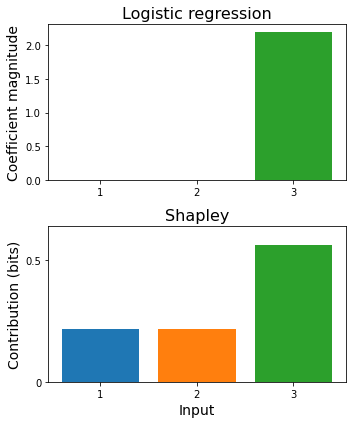

****************************************************************************************************
Beginning circuit #3 aka circuit (c) in Fig. S1.
Circuit spec: [0, 1, 2, 3, [0, 2, 0], [2, 4, 3], [0, 5, 1]]
****************************************************************************************************
Finished step 0/50000
Finished step 5000/50000
Finished step 10000/50000
Finished step 15000/50000
Finished step 20000/50000
Finished step 25000/50000
Finished step 30000/50000
Finished step 35000/50000
Finished step 40000/50000
Finished step 45000/50000

Finished training, onto plotting


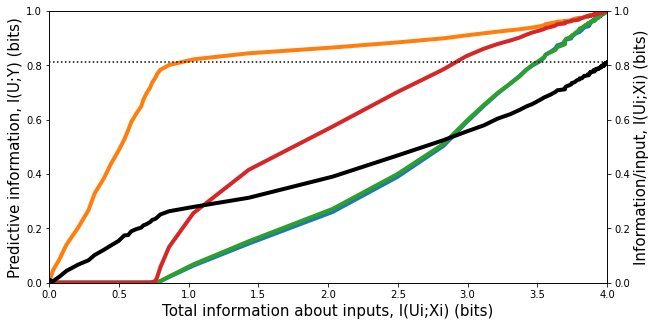

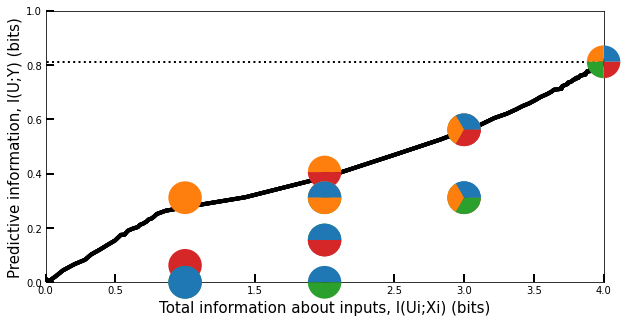

Logistic regression accuracy: 0.875
Logistic regression coefficients: [9.61762992e-05 1.60583814e+01 9.61762967e-05 2.19734979e+00]
I(U;Y)=0.406 bits, H(Y)=0.811 bits
****************************************************************************************************
H(Y)=0.811, Sum of Shapley values = 0.811
Shapley values: [0.0962198571076538, 0.37685891933722027, 0.0962198571076538, 0.24197949090660467]
****************************************************************************************************


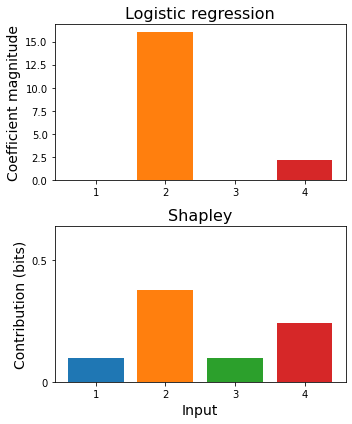

****************************************************************************************************
Beginning circuit #4 aka circuit (d) in Fig. S1.
Circuit spec: [0, 1, 2, 3, [1, 1, 3], [0, 4, 0], [2, 2, 5]]
****************************************************************************************************
Finished step 0/50000
Finished step 5000/50000
Finished step 10000/50000
Finished step 15000/50000
Finished step 20000/50000
Finished step 25000/50000
Finished step 30000/50000
Finished step 35000/50000
Finished step 40000/50000
Finished step 45000/50000

Finished training, onto plotting


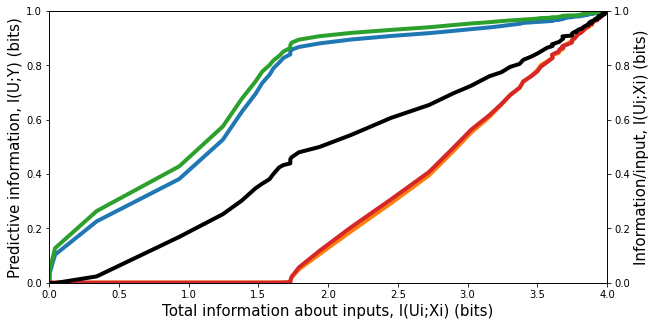

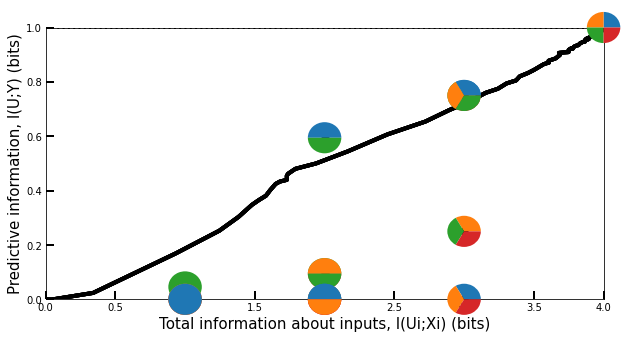

Logistic regression accuracy: 0.625
Logistic regression coefficients: [2.94309227e-08 2.94309226e-08 1.02165097e+00 2.94309226e-08]
I(U;Y)=0.046 bits, H(Y)=1.000 bits
****************************************************************************************************
H(Y)=1.000, Sum of Shapley values = 1.000
Shapley values: [0.3425060887628776, 0.09250608876287761, 0.47248173371136726, 0.09250608876287761]
****************************************************************************************************


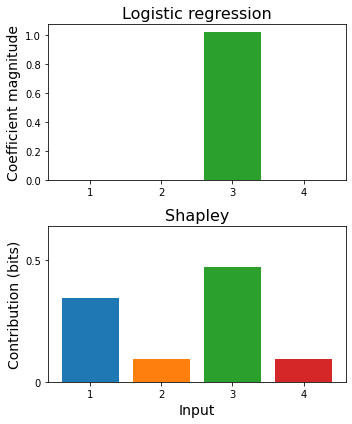

****************************************************************************************************
Beginning circuit #5 aka circuit (e) in Fig. S1.
Circuit spec: [0, 1, 2, 3, 4, [0, 1, 4], [2, 3, 5], [0, 6, 2], [1, 0, 7]]
****************************************************************************************************
Finished step 0/50000
Finished step 5000/50000
Finished step 10000/50000
Finished step 15000/50000
Finished step 20000/50000
Finished step 25000/50000
Finished step 30000/50000
Finished step 35000/50000
Finished step 40000/50000
Finished step 45000/50000

Finished training, onto plotting


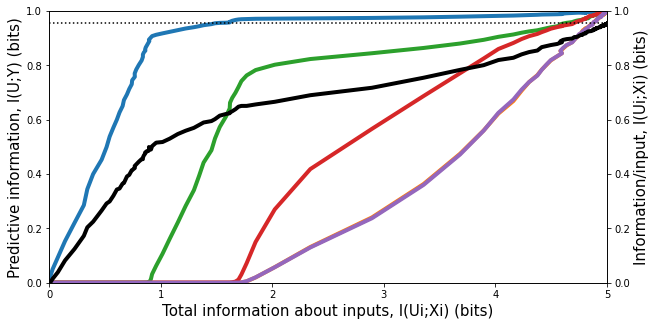

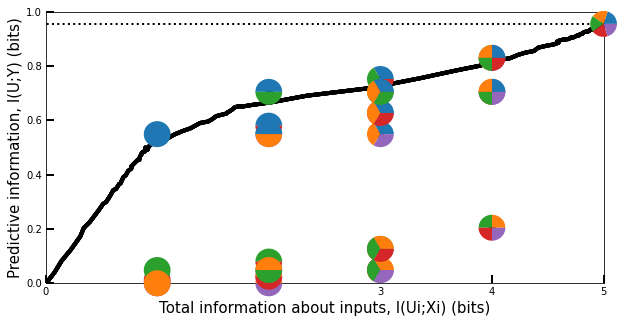

Logistic regression accuracy: 0.938
Logistic regression coefficients: [3.42867555e+01 1.77726771e-06 1.78242757e+01 2.19721259e+00
 1.77726769e-06]
I(U;Y)=0.752 bits, H(Y)=0.954 bits
****************************************************************************************************
H(Y)=0.954, Sum of Shapley values = 0.954
Shapley values: [0.6361993267150806, 0.04121479843161109, 0.13619932671508067, 0.09960575263158164, 0.041214798431611056]
****************************************************************************************************


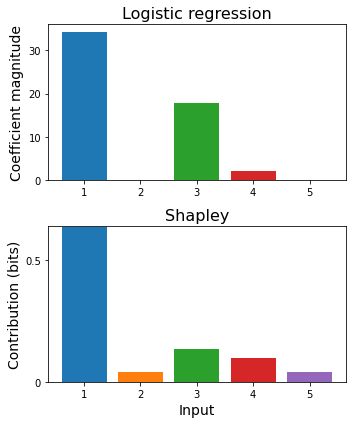

****************************************************************************************************
Beginning circuit #6 aka circuit (f) in Fig. S1.
Circuit spec: [0, 1, 2, 3, 4, 5, [2, 5, 4], [2, 0, 3], [0, 1, 2], [2, 8, 6], [2, 9, 7]]
****************************************************************************************************
Finished step 0/50000
Finished step 5000/50000
Finished step 10000/50000
Finished step 15000/50000
Finished step 20000/50000
Finished step 25000/50000
Finished step 30000/50000
Finished step 35000/50000
Finished step 40000/50000
Finished step 45000/50000

Finished training, onto plotting


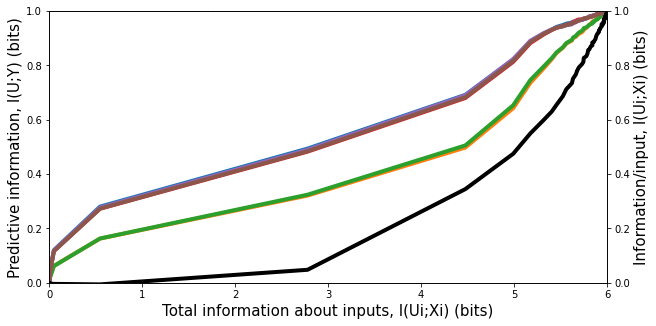

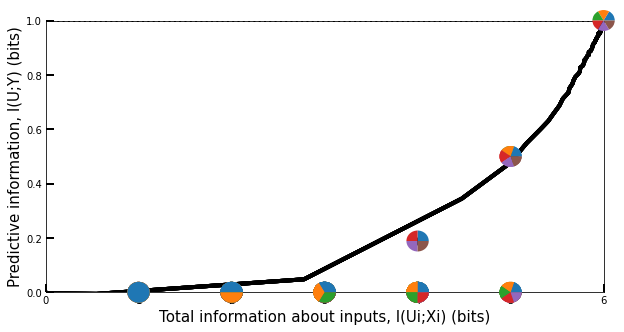

Logistic regression accuracy: 0.500
Logistic regression coefficients: [0. 0. 0. 0. 0. 0.]
I(U;Y)=0.000 bits, H(Y)=1.000 bits
****************************************************************************************************
H(Y)=1.000, Sum of Shapley values = 1.000
Shapley values: [0.20314536459234778, 0.0937092708153044, 0.0937092708153044, 0.2031453645923478, 0.2031453645923478, 0.2031453645923478]
****************************************************************************************************


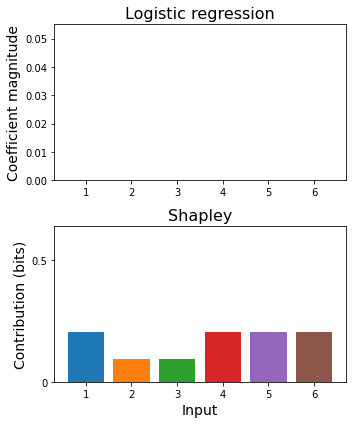

In [ ]:
# These are the 6 circuits in Fig. S1 (a-f)
circuit_specs = [
    [0, 1, 2, [2, 1, 2], [2, 0, 3]],
    [0, 1, 2, [0, 1, 0], [2, 2, 3]],
    [0, 1, 2, 3, [0, 2, 0], [2, 4, 3], [0, 5, 1]],
    [0, 1, 2, 3, [1, 1, 3], [0, 4, 0], [2, 2, 5]],
    [0, 1, 2, 3, 4, [0, 1, 4], [2, 3, 5], [0, 6, 2], [1, 0, 7]],
    [0, 1, 2, 3, 4, 5, [2, 5, 4], [2, 0, 3], [0, 1, 2], [2, 8, 6], [2, 9, 7]]
]
for circuit_ind, circuit_spec in enumerate(circuit_specs):
  print('*'*100)
  print(f'Beginning circuit #{circuit_ind+1} aka circuit ({"abcdef"[circuit_ind]}) in Fig. S1.')
  print('Circuit spec:', circuit_spec)
  print('*'*100)

  number_input_gates = np.sum([1 if type(v) is int else 0 for v in circuit_spec])
  # Now for a full truth table, compute all mutual information terms
  poss_vals = np.meshgrid(*[[0, 1]]*number_input_gates)
  poss_vals = np.stack(poss_vals, -1)
  poss_vals = np.reshape(poss_vals, [-1, number_input_gates])

  truth_table = apply_gates(poss_vals, circuit_spec)
  entropy_y = compute_entropy(truth_table[:, -1])

  learning_rate = 1e-3
  number_training_steps = 5*10**4
  batch_size = 512
  beta_start, beta_end = [1e-3, 1e0]
  opt = tf.keras.optimizers.Adam(learning_rate)
  bce_loss_series = []
  beta_var = tf.Variable(beta_start, dtype=tf.float32, trainable=False)
  ##############################################################################
  # Network creation
  # The encoders are trainable constants, taking each binary 0/1 to a normal
  # distribution in representation space with +-mu as the mean
  #
  # Because we want to use our own feature encoders, we can't easily use the
  # DistributedIBNet class (where each feature encoder is an MLP)
  # This is an example where the loss computation must be done out in the open,
  # defined in train_step()
  feature_encoders = [SimpleEncoder() for _ in range(number_input_gates)]

  predictive_model = tf.keras.Sequential([tf.keras.layers.Input((number_input_gates,)),
            tf.keras.layers.Dense(256, 'leaky_relu'),
            tf.keras.layers.Dense(256, 'leaky_relu'),
            tf.keras.layers.Dense(256, 'leaky_relu'),
            tf.keras.layers.Dense(1)])
  trainable_variables = predictive_model.trainable_variables

  dummy_x = tf.ones((2, 1))
  for network in feature_encoders:
    network(dummy_x)  ## build the network
    trainable_variables += network.trainable_variables

  ##############################################################################
  bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  @tf.function
  def train_step():
    rand_samples = tf.random.categorical(tf.zeros((batch_size, truth_table.shape[0])), 1)
    batch_x = tf.gather(truth_table, rand_samples, axis=0)[:, 0, :number_input_gates]
    batch_x = tf.cast(batch_x, tf.float32)*2. - 1  ## map 0,1 -> -1,1

    batch_y = tf.gather(truth_table, rand_samples, axis=0)[:, 0, -1]
    batch_x_split = tf.split(batch_x, number_input_gates, axis=-1)

    kl_divergence_channels = []
    all_embeddings = []
    with tf.GradientTape() as tape:
      for gate_ind in range(number_input_gates):
        emb_mus, emb_logvars = tf.split(feature_encoders[gate_ind](batch_x_split[gate_ind]), 2, axis=-1)
        emb_reparameterized = tf.random.normal(emb_mus.shape, mean=emb_mus, stddev=tf.exp(emb_logvars/2.))
        all_embeddings.append(emb_reparameterized)
        kl = tf.reduce_mean(tf.reduce_sum(0.5 * (tf.square(emb_mus) + tf.exp(emb_logvars) - emb_logvars - 1.), axis=-1))
        kl_divergence_channels.append(kl)
      y_predicted = predictive_model(tf.concat(all_embeddings, -1))
      bce_loss = tf.reduce_mean(bce(batch_y, y_predicted))
      loss = bce_loss + beta_var*tf.reduce_sum(kl_divergence_channels)
    grads = tape.gradient(loss, trainable_variables)
    opt.apply_gradients(zip(grads, trainable_variables))
    return bce_loss

  evaluate_mutual_info_freq = number_training_steps//200
  mutual_information_bounds = []
  for step in range(number_training_steps):
    # Logarithmically ramp beta over the course of training
    beta_var.assign(np.exp(np.log(beta_start)+float(step)/number_training_steps*(np.log(beta_end)-np.log(beta_start))))
    bce_loss = train_step()
    bce_loss_series.append(bce_loss.numpy())
    if step % evaluate_mutual_info_freq == 0:
      # Estimate the amount of information transmitted by each feature encoder
      for feature_encoder in feature_encoders:
        lower, upper = estimate_mi_sandwich_bounds(feature_encoder, tf.data.Dataset.from_tensor_slices([[-1.], [1]]))
        mutual_information_bounds.append([lower, upper])
    if step % (number_training_steps//10) == 0:
      print(f'Finished step {step}/{number_training_steps}')

  print()
  print('Finished training, onto plotting')

  mutual_information_bounds = np.reshape(mutual_information_bounds, [-1, number_input_gates, 2])/np.log(2)

  plot_lims_info_in_per = [0, 1.]
  plot_lims_info_in_total = [0, 10]
  plot_lims_info_out = [0, 1]

  predictive_information_out = entropy_y - np.float32(bce_loss_series)/np.log(2)

  ## Just take the average of the upper and lower bounds to be the mutual information estimate
  # See the manuscript and/or information bound colab -- the bounds should be separated by
  # no more than ~0.01 bits for the entire optimization
  transmitted_information_by_channel = np.mean(mutual_information_bounds, axis=-1)

  # Average temporally a little bit
  train_smoothing_sigma = 25
  info_parts_smoothing_sigma = 1.5
  info_full_smoothing_sigma = 0.5

  plot_lims_info_in_per = [0, 1.]
  plot_lims_info_in_total = [0, number_input_gates]
  plot_lims_info_out = [0, 1]

  info_in_parts = nim.filters.gaussian_filter1d(transmitted_information_by_channel, info_parts_smoothing_sigma, axis=0)
  info_in_full = nim.filters.gaussian_filter1d(np.sum(transmitted_information_by_channel, axis=-1), info_full_smoothing_sigma)
  predictive_information_out = nim.filters.gaussian_filter(predictive_information_out, train_smoothing_sigma)[::evaluate_mutual_info_freq]

  plt.figure(figsize=(10, 5))
  ax = plt.gca()
  plot_start_ind = 5  # Start plotting after a brief initial warmup
  ax.plot(info_in_full[plot_start_ind:], predictive_information_out[plot_start_ind:], lw=4, color='k')
  ax.plot(plot_lims_info_in_total, [entropy_y]*2, 'k:')
  ax.set_xlim(plot_lims_info_in_total)
  ax.set_ylim(plot_lims_info_out)

  ax2 = ax.twinx()
  for gate_ind in range(number_input_gates):
    ax2.plot(info_in_full[plot_start_ind:], info_in_parts[plot_start_ind:, gate_ind], color=default_colors[gate_ind], lw=4)
  ax2.set_ylim(plot_lims_info_in_per)
  ax.set_zorder(ax2.get_zorder()+1)  # it looks better with the main DIB curve (black) in front of the per-channel information curves
  ax.patch.set_visible(False)

  ax.set_xlabel('Total information about inputs, I(Ui;Xi) (bits)', fontsize=15)
  ax.set_ylabel('Predictive information, I(U;Y) (bits)', fontsize=15)
  ax2.set_ylabel('Information/input, I(Ui;Xi) (bits)', fontsize=15)

  plt.show()

  # Let's look at the information in all subsets
  all_on_off_combos = np.meshgrid(*[[0, 1]]*number_input_gates, indexing='ij')
  all_on_off_combos = np.stack(all_on_off_combos, -1)
  all_on_off_combos = np.reshape(all_on_off_combos, [-1, number_input_gates])
  all_mis = [0]
  for mi_term in all_on_off_combos[1:]:
    # each mi_term is 0s and 1s for if the input is included in the computation or not
    x = np.stack([truth_table[:, i] for i in np.where(mi_term)[0]], -1)
    mi = compute_info(x, truth_table[:, -1])
    all_mis.append(mi)

  plt.figure(figsize=(10, 5))

  pie_rad = 0.15
  ax = plt.gca()
  ax.plot(info_in_full[plot_start_ind:], predictive_information_out[plot_start_ind:], lw=4, color='k')
  for num_terms in range(1, number_input_gates+1):
    ixy = np.float32(all_mis)[np.where(np.sum(all_on_off_combos, -1)==num_terms)]
    inds = np.float32(all_mis)[np.where(np.sum(all_on_off_combos, -1)==num_terms)]
    # plt.scatter(np.ones(len(ixy))*num_terms, ixy/np.log(2), s=8, c='k')
    # for info_index, bit_inclusion in enumerate(all_on_off_combos[np.where(np.sum(all_on_off_combos, -1)==num_terms)][inds]):
    #   on_gates = np.where(bit_inclusion)
    #   if np.any([list(on_gates[0])==list(active_combo) for active_combo in active_combos]):
    #     plt.scatter(num_terms, ixy[info_index]/np.log(2), s=150, c=default_colors[info_index])
    #     break
    # for combo_ind in range(info_ins_all.shape[0]):
    for info_index, bit_inclusion in enumerate(all_on_off_combos[np.where(np.sum(all_on_off_combos, -1)==num_terms)]):
      on_gates = np.where(bit_inclusion)[0]
      if len(on_gates):
        axins = ax.inset_axes([num_terms-pie_rad, ixy[info_index]-pie_rad, 2*pie_rad, 2*pie_rad], transform=ax.transData)
        axins.pie(np.ones_like(on_gates), colors=[default_colors[ind] for ind in on_gates])
        # plt.axis('off')

  for subset_size in range(1, number_input_gates+1):
    mutual_infos_sorted = np.sort(np.float32(all_mis)[np.where(np.sum(all_on_off_combos, -1)==subset_size)])[::-1]
    combination_indices = np.argsort(np.float32(all_mis)[np.where(np.sum(all_on_off_combos, -1)==subset_size)])[::-1]
    plt.scatter(np.ones(len(mutual_infos_sorted))*subset_size, mutual_infos_sorted, s=50, c='k')

    for info_index, bit_inclusion in enumerate(all_on_off_combos[np.where(np.sum(all_on_off_combos, -1)==subset_size)][combination_indices]):
      on_gates = np.where(bit_inclusion)
      ## Blow up the point for the subset found by the distributed IB, and color it based on its rank
      ## out of all the same sized subsets.  Blue = max, orange is second, green third, etc. (following matplotlib's default color cycle)

    plt.plot(info_in_full[plot_start_ind:], predictive_information_out[plot_start_ind:], lw=4, color='k')

  plt.plot([-1, number_input_gates+1], [entropy_y]*2, 'k:', lw=2)
  plt.xlabel('Total information about inputs, I(Ui;Xi) (bits)', fontsize=15)
  plt.ylabel('Predictive information, I(U;Y) (bits)', fontsize=15)
  plt.xlim(plot_lims_info_in_total)
  plt.ylim(plot_lims_info_out)
  plt.tick_params(which='both', width=2, length=8, direction='in')
  plt.show()
  ##############################################################################
  # Use logistic regression on the truth table to assess the importance of the inputs
  # We turn off the L2 penalty since we have the full truth table and want to estimate
  # the max information that the simple model can capture (e.g. logistic regression
  # should capture all of H(Y) for a single AND or OR gate, but this will not be
  # true if the L2 penalty is non zero)
  clf = LogisticRegression(random_state=0, penalty='none').fit(truth_table[:, :number_input_gates], truth_table[:, -1])

  plt.figure(figsize=(5, 6))

  plt.subplot(211)
  plt.bar(range(number_input_gates), clf.coef_[0], color=default_colors[:number_input_gates])
  plt.xticks(range(number_input_gates), range(1, number_input_gates+1))
  plt.ylim(0, None)
  plt.ylabel('Coefficient magnitude', fontsize=14)
  plt.title('Logistic regression', fontsize=16)
  print(f'Logistic regression accuracy: {np.average(clf.predict(truth_table[:, :number_input_gates]) == truth_table[:, -1]):.3f}')
  print('Logistic regression coefficients:', clf.coef_[0])

  xent = np.mean(tf.losses.binary_crossentropy(truth_table[:, -1], clf.predict_proba(truth_table[:, :number_input_gates])[:, 1]))/np.log(2)
  print(f'I(U;Y)={entropy_y-xent:.3f} bits, H(Y)={entropy_y:.3f} bits')
  print('*'*100)
  ##############################################################################
  # Compute the Shapley values with regards to the mutual information with Y
  # Following SAGE (Covert et al. 2020)
  all_mis = np.reshape(all_mis, [2]*number_input_gates)
  shapley_values = []
  for gate_ind in range(number_input_gates):

    shapley_terms = all_mis.take(1, axis=gate_ind) - all_mis.take(0, axis=gate_ind)

    shapley_terms = np.reshape(shapley_terms, [-1])
    binary_rep = np.stack(np.meshgrid(*[[0, 1]]*(number_input_gates-1)), -1)
    number_terms_each = np.reshape(np.sum(binary_rep, -1), [-1])
    shapley_coeff = comb(number_input_gates-1, number_terms_each)

    shapley_value = np.sum(shapley_terms/shapley_coeff) / number_input_gates
    shapley_values.append(shapley_value)
  print(f'H(Y)={entropy_y:.3f}, Sum of Shapley values = {np.sum(shapley_values):.3f}')
  print('Shapley values:', shapley_values)
  print('*'*100)

  plt.subplot(212)
  plt.bar(range(number_input_gates), shapley_values, color=default_colors[:number_input_gates])
  plt.xticks([])
  plt.ylim(0, 0.64)
  plt.yticks([0, 0.5], [0, 0.5])
  plt.xticks(range(number_input_gates), range(1, number_input_gates+1))

  plt.xlabel('Input', fontsize=14)
  plt.ylabel('Contribution (bits)', fontsize=14)
  plt.title('Shapley', fontsize=16)
  plt.tight_layout()
  plt.show()